In [9]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset

configs = {
    "sst2": {
        "globenc_path": lambda epoch : f"/home/modaresi/projects/globenc_analysis/outputs/globencs/sst2-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": "/home/modaresi/projects/globenc_analysis/outputs/models/output_sst2_bert-base-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "mnli": {
        "globenc_path": lambda epoch : f"/home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    }
}

CONFIG = configs["mnli"]  # sst2/mnli

In [2]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    print(f"Read {path}")
    return data

In [3]:
globencs = list()  # [epoch, {globenc, tokens}, #]
for epoch in tqdm(range(6)):
    data = load_pickle(CONFIG["globenc_path"](epoch))
    globencs.append(data)

  0%|          | 0/6 [00:00<?, ?it/s]

Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e0_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e1_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e2_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e3_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e4_train_bert-base-uncased.pickle
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e5_train_bert-base-uncased.pickle


In [36]:
def torch_pearson(x1, x2): # 1D tensor, 1D tensor -> scalar (Pearson Correlation)
    m1 = x1.mean()
    m2 = x2.mean()
    d1 = x1 - m1
    d2 = x2 - m2
    Cxy = torch.sum(d1*d2)
    Cxx = torch.sum(d1*d1)
    Cyy = torch.sum(d2*d2)
    return Cxy/(Cxx*Cyy).sqrt()

def calc_pRSA(i, v1, v2): # Calculates pointwise RSA [index, Vectorspace1, Vectorspace2]
    mask = ~torch.nn.functional.one_hot(torch.tensor(i), v1.shape[0]).bool()
    sims_e0 = torch.nn.functional.cosine_similarity(v1[mask], v1[i], dim=1, eps=1e-08)
    sims_e1 = torch.nn.functional.cosine_similarity(v2[mask], v2[i], dim=1, eps=1e-08)
    return torch_pearson(sims_e0, sims_e1)

In [16]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
# all_cls_e0 = torch.tensor(globencs[epoch_i]["cls"]).cuda()
# all_cls_e1 = torch.tensor(globencs[epoch_i+1]["cls"]).cuda()
all_cls = [torch.tensor(globencs[i]["cls"]).cuda() for i in range(len(globencs))]
# pRSA = np.zeros(all_cls[0].shape[0])
# pearsons = np.zeros(all_cls[0].shape[0])

In [ ]:
for i in tqdm(range(all_cls_e0.shape[0])):
    pRSA[i] = calc_pRSA(i, all_cls_e0, all_cls_e1).cpu()
    pearsons[i] = pearsonr(globencs[epoch_i]["globenc"][i][0], globencs[epoch_i+1]["globenc"][i][0])[0]

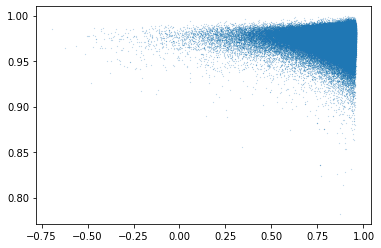

In [96]:
plt.scatter(pRSA, pearsons, s=.01)

In [97]:
def get_nonoutlier_range(x):
    Q_1 = np.quantile(x, 0.25)
    Q_3 = np.quantile(x, 0.75)
    IQR = Q_3 - Q_1
    min_whisker = max(x.min(), Q_1 - 1.5 * IQR)
    max_whisker = min(x.max(), Q_3 + 1.5 * IQR)
    return min_whisker, max_whisker

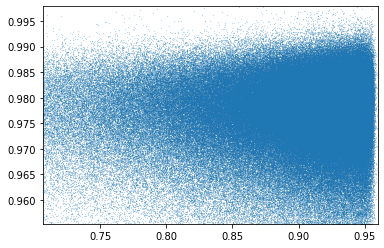

In [102]:
plt.scatter(pRSA, pearsons, s=.01)
plt.xlim(get_nonoutlier_range(pRSA))
plt.ylim(get_nonoutlier_range(pearsons))
plt.show()

In [7]:
def load_logits(dir_path: str):
    file_list = os.listdir(dir_path)
    file_list.sort()
    print("Loading files in:", dir_path)
    idxs, logits = [], []
    for file_name in file_list:
        print(file_name)
        file_path = f"{dir_path}/{file_name}"
        if "idxs" in file_path:
            idxs.append(np.array(torch.load(file_path)))
        elif "logits" in file_path:
            logits.append(np.array(torch.load(file_path)))
        else:
            raise Exception("Wrong Files!")
    logits_ordered = np.zeros(np.array(logits).shape)
    for epoch in range(len(idxs)):
        logits_ordered[epoch][idxs[epoch]] = logits[epoch]
    return logits_ordered

def el2n(logits, labels):
    logits = torch.tensor(logits)  # (3, 392702, 3)
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=max(labels) + 1)  # (392702, 3)
    scores = []
    for epoch in range(len(logits)):
        errors = torch.nn.functional.softmax(logits[epoch], dim=-1) - labels
#         score = torch.linalg.vector_norm(errors, dim=-1, ord=2)
        score = np.linalg.norm(errors, ord=2, axis=-1)
        scores.append(score)
    return np.mean(np.array(scores), axis=0)

def cartography(logits, true_labels):
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    corr_probs = np.sum(probs * np.expand_dims(torch.nn.functional.one_hot(true_labels, num_classes=max(true_labels) + 1).numpy(), axis=0), axis=-1)
    confs = np.mean(corr_probs, axis=0)
    variabilities = np.std(corr_probs, axis=0)
    return confs, variabilities

In [10]:
logits = load_logits(CONFIG["logits_path"])
logits.shape

Loading files in: /home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch
epoch0_step012272_after_epoch_train_idxs_[392702].pt
epoch0_step012272_after_epoch_train_logits_[392702, 3].pt
epoch1_step024544_after_epoch_train_idxs_[392702].pt
epoch1_step024544_after_epoch_train_logits_[392702, 3].pt
epoch2_step036816_after_epoch_train_idxs_[392702].pt
epoch2_step036816_after_epoch_train_logits_[392702, 3].pt
epoch3_step049088_after_epoch_train_idxs_[392702].pt
epoch3_step049088_after_epoch_train_logits_[392702, 3].pt
epoch4_step061360_after_epoch_train_idxs_[392702].pt
epoch4_step061360_after_epoch_train_logits_[392702, 3].pt


(5, 392702, 3)

In [11]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
confs, vars = cartography(torch.tensor(logits), torch.tensor(ds['label']))

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [23]:
np.argsort(vars)[-10:]

array([ 37487, 187926, 161115, 326809,  44065, 120677, 330701,  24499,
       362215, 362144])

In [51]:
import json
from scipy.stats import pearsonr

for idx in np.argsort(vars)[-10:]:
    print("Example", idx, "-- Var:", vars[idx])
    print(json.dumps(ds[int(idx)], indent=4))
    for ep in range(5):
        pRSA = calc_pRSA(idx, all_cls[ep], all_cls[ep+1]).cpu().numpy()
        pearson = pearsonr(globencs[ep]["globenc"][idx][0], globencs[ep+1]["globenc"][idx][0])[0]
        cosine_sim = torch.nn.functional.cosine_similarity(all_cls[ep][idx].unsqueeze(dim=0), all_cls[ep+1][idx].unsqueeze(dim=0)).cpu().numpy()[0]
        print_globenc(globencs[ep]["globenc"][idx], globencs[ep]["tokens"][idx])
        print(f"Epoch {ep} -> {ep+1} :: GlobencPearson:", pearson, "pRSA:", pRSA, "Final logits:", logits[ep, idx], "Cosine Sim:", cosine_sim)
    print_globenc(globencs[ep+1]["globenc"][idx], globencs[ep]["tokens"][idx])
    print("")

Example 37487 -- Var: 0.47941832338884566
{
    "premise": "The Galleria provides a sheltered, much trafficked pedestrian passage from the Duomo to another holy entity, the revered 18th-century La Scala theater, high temple of opera.",
    "hypothesis": "The Galleria is a famous theater.",
    "label": 2,
    "idx": 37487
}


Epoch 0 -> 1 :: GlobencPearson: 0.9360165018137605 pRSA: 0.031778254 Final logits: [ 0.97247779  1.53830814 -2.84850645] Cosine Sim: 0.57342803


Epoch 1 -> 2 :: GlobencPearson: 0.9789647240451673 pRSA: 0.8710371 Final logits: [-0.73839158  2.18780899 -1.35764551] Cosine Sim: 0.8916453


Epoch 2 -> 3 :: GlobencPearson: 0.9939924765922759 pRSA: -0.36018106 Final logits: [-2.83680439 -0.73915964  3.77764821] Cosine Sim: 0.56354827


Epoch 3 -> 4 :: GlobencPearson: 0.99744797031876 pRSA: 0.897699 Final logits: [-3.53070688 -2.02808309  5.8272047 ] Cosine Sim: 0.7706714


Epoch 4 -> 5 :: GlobencPearson: 0.9996131828099037 pRSA: 0.99112415 Final logits: [-3.47975612 -2.73228192  6.56798744] Cosine Sim: 0.94107497



Example 187926 -- Var: 0.4797660548812024
{
    "premise": "The direct health effects of nitrogen oxide gases and sulfur dioxide gases are also unquantified.",
    "hypothesis": "The health effects of nitrogen oxide gases and sulfur dioxide gases are also unknown but we have the reports of negative effects.",
    "label": 2,
    "idx": 187926
}


Epoch 0 -> 1 :: GlobencPearson: 0.7883928128003378 pRSA: -0.03383258 Final logits: [-0.53547639  2.95910287 -2.57176876] Cosine Sim: 0.21059188


Epoch 1 -> 2 :: GlobencPearson: 0.9622856770022955 pRSA: 0.8114791 Final logits: [-1.21047223  2.3746767  -1.05661404] Cosine Sim: 0.8526235


Epoch 2 -> 3 :: GlobencPearson: 0.9891612020483629 pRSA: -0.25232893 Final logits: [-2.46522546 -1.20243645  3.86706543] Cosine Sim: 0.5620147


Epoch 3 -> 4 :: GlobencPearson: 0.992383157765919 pRSA: 0.9219547 Final logits: [-3.03698397 -1.47393441  4.71477127] Cosine Sim: 0.94935274


Epoch 4 -> 5 :: GlobencPearson: 0.998894053877857 pRSA: 0.97922105 Final logits: [-3.2638166  -2.1265831   5.66121721] Cosine Sim: 0.951708



Example 161115 -- Var: 0.479794400014052
{
    "premise": "Cabaret entertainment can be found at the Cinegrille in the Hollywood Roosevelt Hotel.",
    "hypothesis": "The Cinegrille in the Hollywood Roosevelt Hotel features Cabaret entertainment and dance.",
    "label": 0,
    "idx": 161115
}


Epoch 0 -> 1 :: GlobencPearson: 0.906513535118421 pRSA: -0.04338282 Final logits: [-0.78250164  3.27868629 -2.4723258 ] Cosine Sim: 0.13615014


Epoch 1 -> 2 :: GlobencPearson: 0.9848467882536133 pRSA: 0.922021 Final logits: [-0.71790129  3.66095448 -3.05144572] Cosine Sim: 0.9467117


Epoch 2 -> 3 :: GlobencPearson: 0.9912343989296851 pRSA: 0.24474923 Final logits: [ 4.04032326 -0.70144498 -3.78638721] Cosine Sim: 0.33265945


Epoch 3 -> 4 :: GlobencPearson: 0.9979692209726455 pRSA: 0.96821827 Final logits: [ 4.38554239 -0.61721092 -4.15563536] Cosine Sim: 0.9566002


Epoch 4 -> 5 :: GlobencPearson: 0.9997468633323137 pRSA: 0.9836311 Final logits: [ 4.88455534 -1.33427727 -3.9748292 ] Cosine Sim: 0.96592504



Example 326809 -- Var: 0.48052979589335615
{
    "premise": "And now the big boys want to cash in.",
    "hypothesis": "The boys want to withdraw their funds.",
    "label": 0,
    "idx": 326809
}


Epoch 0 -> 1 :: GlobencPearson: 0.9120022411391672 pRSA: -0.031644225 Final logits: [-1.55751967 -1.20937741  2.9425416 ] Cosine Sim: 0.23026355


Epoch 1 -> 2 :: GlobencPearson: 0.9802292491652967 pRSA: 0.887135 Final logits: [-1.39664626 -2.07701802  3.88546968] Cosine Sim: 0.92703867


Epoch 2 -> 3 :: GlobencPearson: 0.995196128527943 pRSA: 0.8676793 Final logits: [-0.59667015 -2.01587319  2.9443872 ] Cosine Sim: 0.93376714


Epoch 3 -> 4 :: GlobencPearson: 0.9977982550022777 pRSA: 0.4212789 Final logits: [ 3.67499042 -1.70071721 -2.33349562] Cosine Sim: 0.644958


Epoch 4 -> 5 :: GlobencPearson: 0.9996957195345149 pRSA: 0.9838096 Final logits: [ 4.41588879 -2.1873436  -2.61309528] Cosine Sim: 0.9685706



Example 44065 -- Var: 0.4809748776144424
{
    "premise": "The product itself won't be in stores until summer, so it's way too early to know how the shaving public will respond.",
    "hypothesis": "The product itself won't be in stores until summer, so it's way too early to know how well the shaving product will be received.",
    "label": 1,
    "idx": 44065
}


Epoch 0 -> 1 :: GlobencPearson: 0.9007292741061846 pRSA: 0.17873228 Final logits: [ 2.85616088 -1.22637725 -2.26737785] Cosine Sim: 0.54346323


Epoch 1 -> 2 :: GlobencPearson: 0.9618178742250755 pRSA: 0.9465006 Final logits: [ 3.3092382  -0.77131146 -2.94564366] Cosine Sim: 0.8967519


Epoch 2 -> 3 :: GlobencPearson: 0.9445698303026934 pRSA: 0.017578932 Final logits: [-1.66479766  4.27067232 -2.6979816 ] Cosine Sim: 0.23993269


Epoch 3 -> 4 :: GlobencPearson: 0.9950075808208718 pRSA: 0.9570997 Final logits: [-2.419976    4.95810318 -2.71668077] Cosine Sim: 0.93229985


Epoch 4 -> 5 :: GlobencPearson: 0.9978241522101331 pRSA: 0.98989767 Final logits: [-2.66039586  5.66582012 -3.23725414] Cosine Sim: 0.9834477



Example 120677 -- Var: 0.48222075959256144
{
    "premise": "Johnson, John M. Doing Field Research.",
    "hypothesis": "John Johnson is being field researched.",
    "label": 2,
    "idx": 120677
}


Epoch 0 -> 1 :: GlobencPearson: 0.9549258631266047 pRSA: 0.10836782 Final logits: [ 2.95410013 -1.15804696 -2.33144021] Cosine Sim: 0.6353487


Epoch 1 -> 2 :: GlobencPearson: 0.9666254719029792 pRSA: 0.8983589 Final logits: [ 2.53043365 -1.08838296 -1.68310654] Cosine Sim: 0.884217


Epoch 2 -> 3 :: GlobencPearson: 0.9923630107528166 pRSA: 0.95149505 Final logits: [ 2.56804109 -1.2583003  -1.52281213] Cosine Sim: 0.98204535


Epoch 3 -> 4 :: GlobencPearson: 0.9940026542244355 pRSA: 0.24951051 Final logits: [-1.48086667 -1.9692384   3.91872835] Cosine Sim: 0.6429976


Epoch 4 -> 5 :: GlobencPearson: 0.9997782985193922 pRSA: 0.90482265 Final logits: [-2.74119473 -2.36086226  5.46501446] Cosine Sim: 0.8944869



Example 330701 -- Var: 0.48254914409693384
{
    "premise": "During the reporting period, LSC issued a revised final rule on recipient fund balances, 44 CFR Part 1628.",
    "hypothesis": "The LSC makes many mysterious changes to their rules.",
    "label": 2,
    "idx": 330701
}


Epoch 0 -> 1 :: GlobencPearson: 0.847557969771666 pRSA: -0.03528314 Final logits: [-1.72776556  3.43236899 -1.64548266] Cosine Sim: 0.16445622


Epoch 1 -> 2 :: GlobencPearson: 0.9738635171925296 pRSA: 0.9217248 Final logits: [-2.68829942  3.55940723 -0.71198416] Cosine Sim: 0.9066732


Epoch 2 -> 3 :: GlobencPearson: 0.9888700472590334 pRSA: 0.028319709 Final logits: [-3.64653182 -0.16763408  4.11889696] Cosine Sim: 0.4457451


Epoch 3 -> 4 :: GlobencPearson: 0.9979293141035296 pRSA: 0.9267704 Final logits: [-4.05179501 -1.31519282  5.52828026] Cosine Sim: 0.8501802


Epoch 4 -> 5 :: GlobencPearson: 0.9991208002990737 pRSA: 0.9755937 Final logits: [-3.72096682 -2.34037685  6.30121565] Cosine Sim: 0.9517331



Example 24499 -- Var: 0.4839834701090803
{
    "premise": "At least half the pleasure is in the bargaining.",
    "hypothesis": "Half of the joys from the trip are from the bargaining.",
    "label": 0,
    "idx": 24499
}


Epoch 0 -> 1 :: GlobencPearson: 0.9646241799109609 pRSA: -0.045926288 Final logits: [-1.44679236  3.9496839  -2.7186029 ] Cosine Sim: 0.079050034


Epoch 1 -> 2 :: GlobencPearson: 0.9827147099747959 pRSA: 0.92939717 Final logits: [-1.42060924  4.19683695 -2.88968301] Cosine Sim: 0.94973594


Epoch 2 -> 3 :: GlobencPearson: 0.993094743527061 pRSA: 0.9441908 Final logits: [-0.51631325  3.87826633 -3.51050353] Cosine Sim: 0.946205


Epoch 3 -> 4 :: GlobencPearson: 0.9943665410704812 pRSA: 0.21913639 Final logits: [ 4.27716351 -0.46410403 -4.19324875] Cosine Sim: 0.33593008


Epoch 4 -> 5 :: GlobencPearson: 0.9996802388926601 pRSA: 0.9770394 Final logits: [ 5.05952644 -1.31127608 -4.16567421] Cosine Sim: 0.93741286



Example 362215 -- Var: 0.48466425680293457
{
    "premise": "Six weeks ago a Times op-ed piece by political scientist Lucian Pye explored the formidable mindset that governs China today.",
    "hypothesis": "Six weeks ago a Times op-ed piece by political scientist explored the peaceful mindset that governs China today.",
    "label": 1,
    "idx": 362215
}


Epoch 0 -> 1 :: GlobencPearson: 0.8027034000369422 pRSA: -0.10032187 Final logits: [-2.17797971 -1.44768441  3.97988701] Cosine Sim: -0.20262818


Epoch 1 -> 2 :: GlobencPearson: 0.9721032381448009 pRSA: 0.88191956 Final logits: [-3.08393383 -0.48352396  3.97452569] Cosine Sim: 0.8827653


Epoch 2 -> 3 :: GlobencPearson: 0.9804729142903242 pRSA: -0.3322252 Final logits: [-1.72922683  3.9458971  -2.19258952] Cosine Sim: 0.2977488


Epoch 3 -> 4 :: GlobencPearson: 0.9944700206207542 pRSA: 0.95209205 Final logits: [-1.9472158   4.58332539 -2.86069155] Cosine Sim: 0.91968477


Epoch 4 -> 5 :: GlobencPearson: 0.9991995113708383 pRSA: 0.98895574 Final logits: [-2.104316    5.25660896 -3.52431703] Cosine Sim: 0.984668



Example 362144 -- Var: 0.48490814088038203
{
    "premise": "Since the National Trust was founded, the area has benefited from increasing protection.",
    "hypothesis": "With the founding of the national trust the area has remained completely pristine and unpolluted.",
    "label": 1,
    "idx": 362144
}


Epoch 0 -> 1 :: GlobencPearson: 0.8683977985256164 pRSA: -0.051338706 Final logits: [-2.40582132 -1.10392904  3.88508701] Cosine Sim: 0.016988877


Epoch 1 -> 2 :: GlobencPearson: 0.9674960252839953 pRSA: 0.9352505 Final logits: [-3.84251428 -0.53763628  4.61528826] Cosine Sim: 0.8785722


Epoch 2 -> 3 :: GlobencPearson: 0.9858195045944596 pRSA: -0.35063207 Final logits: [-1.74585569  3.64774513 -1.83134997] Cosine Sim: 0.30730715


Epoch 3 -> 4 :: GlobencPearson: 0.9970452130751735 pRSA: 0.8986204 Final logits: [-2.77811694  4.47700167 -1.70923781] Cosine Sim: 0.86490405


Epoch 4 -> 5 :: GlobencPearson: 0.9992921473428648 pRSA: 0.98217314 Final logits: [-2.52266145  5.5532279  -3.33056951] Cosine Sim: 0.9435178


In [49]:
from IPython.display import display, HTML
def print_globenc(globenc, tokenized_text, discrete=False, prefix=""): 
    if len(globenc.shape) == 2: 
        globenc = np.expand_dims(globenc, axis=0) 
    norm_cls = globenc[:, 0, :] 
    norm_cls = np.flip(norm_cls, axis=0) 
    row_sums = norm_cls.max(axis=1) 
    norm_cls = norm_cls / row_sums[:, np.newaxis] 
    html = prefix 
    if discrete: 
        cls_attention = np.argsort(np.argsort(norm_cls[0, :])) / len(norm_cls[0, :]) 
    else: 
        cls_attention = norm_cls[0, :] 
    for i in range(len(tokenized_text)): 
        html += (f"<span style='background-color: rgba(10, {cls_attention[i]*255}, 10, {cls_attention[i] / 1.5}); " 
                 f"font-size: {int(cls_attention[i]*18 + 1)}px; " 
                 f"font-weight: {int(cls_attention[i]*900)};'>") 
        html += tokenized_text[i] 
        html += "</span> " 
    display(HTML(html))

In [ ]:
print_globenc(globencs[i]["globenc"][idx], globencs[i]["tokens"][idx])